# Better Bookmarks Bookmark Categorization ML Model

---



UCSC CMPS 115 Project

Notebook and Code Authored by Nicholas Williams

7/8/2019


---
## Description

This Notebook contains the code to train a machine learning model to categorize bookmarks based off of either the webpage title or the description into 13 pre-defined categories. It also contains an overview of the dataset used and the preprocessing.
## Dataset

The ML team (Nick, Hyun, and Jospeh) made a google spreadsheet detailing several possible datasets, tutorials on them, and their benefits and drawbacks. 

The dataset chosen was the DMOZ dataset which is a snapshot of the DMOZ or directory Mozilla website that was a directory of websites used in the late 90's and early 2000's.
 
   ![Taken From Wikipediat](https://drive.google.com/uc?id=1NyaLM8w7zYM7wzF_C3G1QRkFlgXXnw9q)
 
 This dataset classifies webpage category using titles and descriptions on 13 categories
 
 [Arts, Business, Computers, Games, Health, Home, News, Recreation, Reference, Science, Shopping, Society, Sports].
 
 The dataset consists of 1.2 Million instances of  (Category, Webpage Title, Webpage Description).
 
 Heres some example data points
 
 ![alt text](https://drive.google.com/uc?id=1IPyAN8xluH7tM1Ti6ACqb1Lc9twiJuHz)
 

---


 
## Data Preprocessing
All 1.2M data instances were randomly shuffled and 70K left to use to train and test our model with initially. All 13 categories of websites were made numerical [0-12] using a script provided by Joseph Rodrigues. We used a sequence length of 7 words, text sequences with less than 7 were zero padded.


---
## Model Architecture
The ML model used here is a two layer LSTM neural network with a trainable word embedding layer seeded with pre-trained embeddings. The word embeddings layer has 48,000 words in it and each word resides in an embedding space of dimension 100. The pre-trained embeddings used were the open-source Stanford NLP Group [GLOVE](https://nlp.stanford.edu/projects/glove/) Twitter based word embeddings.
## Training
The train/valid/test split was as follows 54,000/6,000/10,000.

The model trained at a rate of 134 instances/second using our Google Colab provided Tesla K80 GPU which has 12 GB of RAM and 4 TFLOPS of compute.

The model trained on webpage titles achieved it's highest validation accuracy of 55% after the first epoch, after 9 epochs the model was overfitting to the training set and it degraded to validation accuracy of 52%. Note that random guessing for 13 categories would be 1/13 == correct 7.7% of the time, whereas our model is correct 55% of the time. The test accuracy was 52% which coincides with the final validation accuracy.

## Future Work

Ideally we would train until we acheive a high accuracy on the training set, and see how the validation set performs. Training on more data (30 min per epoch amount of data seems reasonable) would help reduce variance. Regularization techniques like dropout could prove useful to reduce variance as well.

We want to try training the model using the webpage descriptions instead of the title as that might prove to yield better results.

We want to simulate a real users data and test on our model, to accomplish this we are planning to create a real google account with 1,000 realistic manually categorized bookmarks. Of course this would not be a true random sample of which to test on because of our human bias, but it's a good start.

## Training Instructions On Google Colab For Reproducibility


1.   Import files into your google drive

      [Glove Twitter Based 100D Word Vectors](https://nlp.stanford.edu/projects/glove/) aka "glove.twitter.27B.100d.txt"

      [DMOZ shuffled and trimmed dataset](https://drive.google.com/open?id=1nmj8OWCZc335JCrVuepaKtslskxdeCoL) aka "102500DmozShuffled.csv"


2.   Link your drive account by running the two code cells below this one

3. Run the main code block to train






 
 
 
 
 
 
 

In [1]:
 from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd gdrive/'My Drive'

/content/gdrive/My Drive


Loaded 48344 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 7, 100)            5293400   
_________________________________________________________________
lstm_29 (LSTM)               (None, 7, 100)            80400     
_________________________________________________________________
lstm_30 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_15 (Dense)             (None, 13)                1313      
Total params: 5,455,513
Trainable params: 5,455,513
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 7, 100)            5293400   
__________________________________

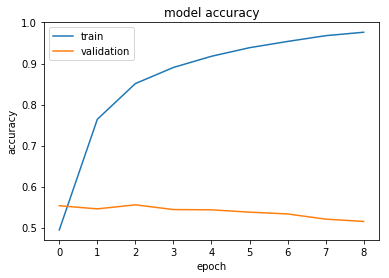

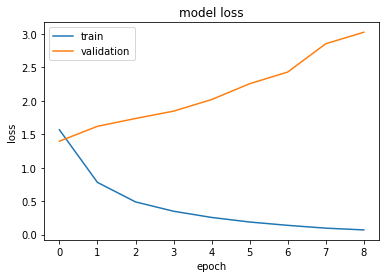

10000/10000 [==============================] - 3s 350us/step
['loss', 'acc', 'categorical_accuracy']
Loss:  3.0215996688842774
Test Accuracy:  0.5024
Categorical accuracy:  0.5024
Saving model to the disk...
Model created


In [24]:
#Nicholas Williams
#ID: 1597706
#UCSC CMPS 115 Software Engineering
#Bookmark Categorization model
#Note this model was in part adapted from my CMPS 142 class project with
#all code written by me though.
#7/8/2019

#This code trains an LSTM using transfer learning on the
#word embeddings using the pre-trained GloVe Stanford NLP Group word embeddings.

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding


from keras.layers import LSTM
from keras.utils import np_utils
from keras.models import Model
from keras import metrics


from keras.models import model_from_json
import numpy
import os

import nltk
import csv
import string

from joblib import dump, load
import matplotlib.pyplot as plt

#Lists to hold the text review strings, and the integer sentiment labels y.
docs=[] #Python list
labels=([]) #numpy array

#Open csv, read phrases into a string array, and output labels into an array.
#If you want to change from 'title' to 'desc', just change row[1] to row[2]. 
with open('102500DmozShuffled.csv', 'r', newline='') as incsvfile:
    csv_reader = csv.reader(incsvfile, delimiter = ",")
    rownum = 0
    for row in csv_reader:
        rownum += 1
        if(rownum != 1):
          phrase = row[1] 
          label=int(row[3])
          docs.append(phrase)
          labels.append(label)

#These are just the garbage csv headers
docs.pop(0)
labels.pop(0)

#Define dataset size before split
docs=docs[0:70000]
labels=labels[0:70000]
labels = np_utils.to_categorical(labels) #needs to be one hot encoded

#Prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

#Integer encode the documents
encoded_docs = t.texts_to_sequences(docs)

#Pad documents to a max length of 7 words
max_length = 7
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

#Load the whole embedding into memory
embeddings_index = dict()
f = open('glove.twitter.27B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

#Create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
    
#Assign training, validation, and test data.
X_train=padded_docs[0:60000]
y_train=labels[0:60000]

X_test=padded_docs[60000:70000]
y_test=labels[60000:70000]


# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=7, trainable=True)
model.add(e)
#LSTM layer with 100 dimension, and the return_sequences insures full
#connection to the next layer instead of only the last sequence(time) step.
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(13, activation='softmax'))
print(model.summary())

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', metrics.categorical_accuracy])

#Print a summary of the model.
print(model.summary())

'''
#Load the model if continuing to train from a previous model.
model_name="dmozModelTitles.joblib"
model = load(modelName)
print(model_name + " Keras model loaded")
'''


batch_size = 4
num_epochs = 9

history = model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, epochs=num_epochs)

        #Code to plot the accuracy and loss
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

#Print the performance metrics
scores = model.evaluate(X_test, y_test, verbose=1)
print(model.metrics_names)
print("Loss: ",scores[0])
print('Test Accuracy: ', scores[1])
print("Categorical accuracy: ", scores[2])

#Save the model
print("Saving model to the disk...")
dump(model, 'dmozModelTitlesBB.joblib')
print("Model created")